In [93]:
import pandas as pd
import geoplot as gplt
import numpy as np
import os
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import geopandas as gpd
import pycountry
import descartes
import contextily as ctx
from shapely.geometry import Point, Polygon
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from matplotlib.font_manager import FontProperties

In [2]:
df = pd.read_csv("./dataset_incendios.csv", delimiter=";", decimal=",", encoding="iso-8859-1")
df['provincia_id_fixed'] = [str(x).zfill(2) for x in df['provincia_id']]
df['depar_id_temp'] = [str(x).zfill(3) for x in df['departamento_id']]
df['departamento_id_fixed'] = [prov_id + dept_id for prov_id, dept_id in zip([x for x in df['provincia_id_fixed']], [y for y in df['depar_id_temp']])]
new_cols = list(set(df.columns) - set(['depar_id_temp', 'provincia_id', 'departamento_id']))
df = df[new_cols]
geo_provinces = gpd.read_file('./provincias/provincias.shp')
geo_departments = gpd.read_file('./departamentos/departamentos.shp')
geo_departments_centroid = gpd.read_file('./departamentos/departamentos.shp')
geo_departments_centroid['geometry'] = geo_departments_centroid['geometry'].centroid

In [3]:
#fires_by_province = df.groupby("provincia_id").size().reset_index(name='counts')
fires_by_province = df.groupby("provincia_id_fixed")['cant_focos'].agg('sum').reset_index(name='counts')
geo_provinces_to_plot = pd.merge(geo_provinces, fires_by_province, left_on='IN1', right_on='provincia_id_fixed', how='outer')
geo_provinces_to_plot = geo_provinces_to_plot[list(['NAM', 'IN1', 'geometry', 'counts'])].fillna(0)
geo_provinces_to_plot['rank'] = geo_provinces_to_plot['counts'].rank()

In [4]:
sup_by_department = df.groupby('departamento_id_fixed')['sup_afectada'].agg('sum').reset_index(name='counts')
geo_departments_to_plot = pd.merge(geo_departments_centroid, sup_by_department, left_on='IN1', right_on='departamento_id_fixed', how='inner').fillna(0)
geo_departments_to_plot['rank'] = geo_departments_to_plot['counts'].rank()

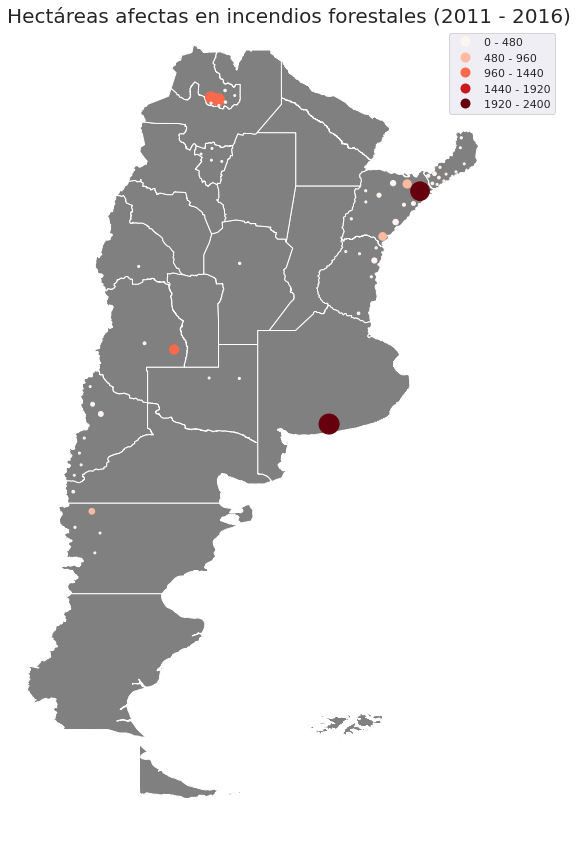

In [5]:
ax = gplt.pointplot(geo_departments_to_plot, scale='counts', hue='counts',
                    scheme='EqualInterval', legend=True, legend_var='hue',
                    limits=(2, 20), figsize=(15, 15), cmap='Reds',
                    legend_kwargs={'loc': 'upper right'})
ax.set_title("Hectáreas afectas en incendios forestales (2011 - 2016)", size=20)
gplt.polyplot(geo_provinces_to_plot, ax=ax, edgecolor='white', facecolor='gray', extent=[-74.0, -57.0, -50.0, -21.0])
plt.savefig('./hectareas_afectadas.png')
plt.box(on=None)

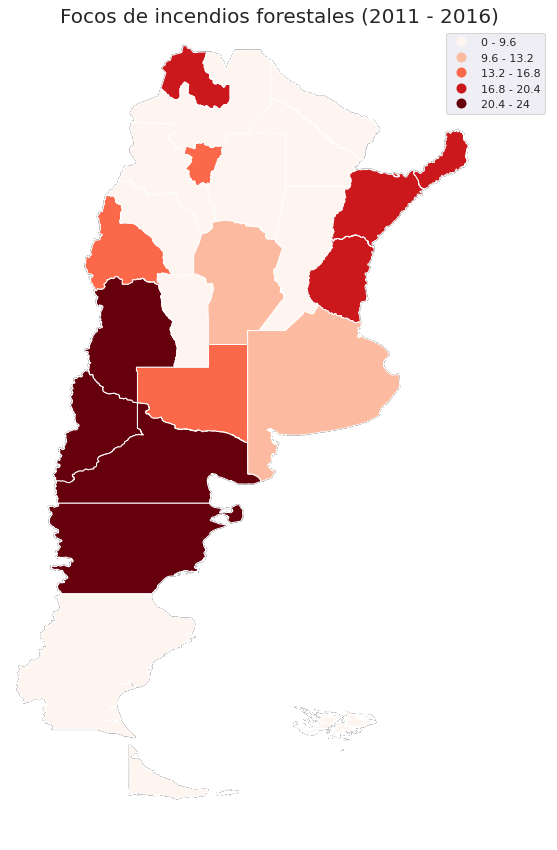

In [6]:
ax = gplt.choropleth(geo_provinces_to_plot, hue='rank', scheme='EqualInterval',
                    legend=True, figsize=(15, 15), cmap='Reds',
                    legend_kwargs={'loc': 'upper right'})
ax.set_title("Focos de incendios forestales (2011 - 2016)", size=20)
gplt.polyplot(geo_provinces_to_plot, ax=ax, extent=[-74.0, -57.0, -50.0, -21.0])
plt.savefig('./focos_totales.png')
plt.box(on=None)

In [8]:
area_by_year = df.groupby('año_inicial')['sup_afectada'].agg('sum').reset_index(name='superficie_total_inicio')
quantity_by_year = df.groupby('año_inicial')['cant_focos'].agg('sum').reset_index(name='focos_total_inicio')
start_by_year = pd.merge(area_by_year, quantity_by_year, on='año_inicial', how='inner')

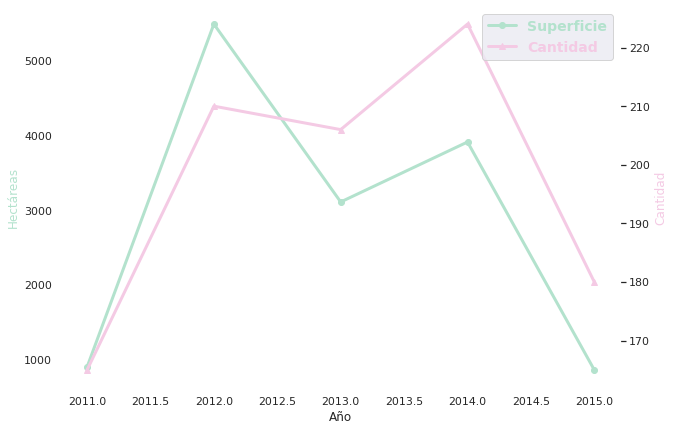

In [9]:
font = FontProperties()
font.set_family('serif')
font.set_name('DejaVu Sans')
font.set_style('italic')

plt.figure(figsize=(10,7))
host = host_subplot(111)
par = host.twinx()

host.set_xlabel("Año")
host.set_ylabel("Hectáreas")
host.set_facecolor('white')
par.set_ylabel("Cantidad")

p1, = host.plot(start_by_year['año_inicial'], start_by_year['superficie_total_inicio'], "o-", color='#b3e2cd', label='Superficie', linewidth=3)
p2, = par.plot(start_by_year['año_inicial'], start_by_year['focos_total_inicio'], "^-", color='#F4CAE4', label='Cantidad', linewidth=3)

font_legend = FontProperties(weight='bold', style='normal', size=14)
leg = plt.legend(prop=font_legend)
host.yaxis.get_label().set_color(p1.get_color())
leg.texts[0].set_color(p1.get_color())
par.yaxis.get_label().set_color(p2.get_color())
leg.texts[1].set_color(p2.get_color())
plt.savefig('./evolucion_anio.png')
plt.show()

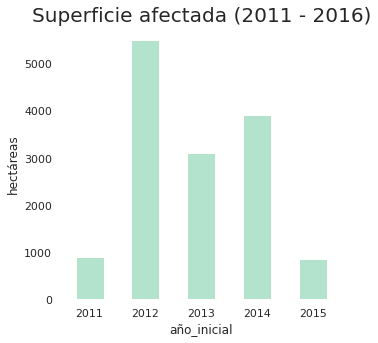

In [10]:
ax = start_by_year.plot.bar(x='año_inicial', y=['superficie_total_inicio'],
                      rot=0, legend=False, figsize=(5, 5), colormap='Pastel2')
ax.set_title("Superficie afectada (2011 - 2016)", size=20)
ax.set_ylabel('hectáreas')
#ax.legend(["Superficie quemada"],loc='upper center', fancybox=True, bbox_to_anchor=(1.2, 1))
plt.box(on=None)

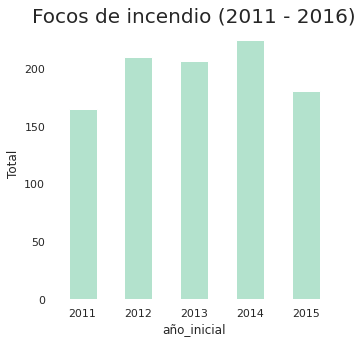

In [12]:
ax = start_by_year.plot.bar(x='año_inicial', y=['focos_total_inicio'],
                      rot=0, legend=False, figsize=(5, 5), colormap='Pastel2')
ax.set_title("Focos de incendio (2011 - 2016)", size=20)
ax.set_ylabel('Total')
#ax.legend(["Focos iniciados", "Focos finalizados"],loc='upper center', fancybox=True, bbox_to_anchor=(1.1, 1))
plt.box(on=None)

In [25]:
area_by_year = df.groupby(['año_inicial', 'provincia'])['sup_afectada'].agg('sum').reset_index()

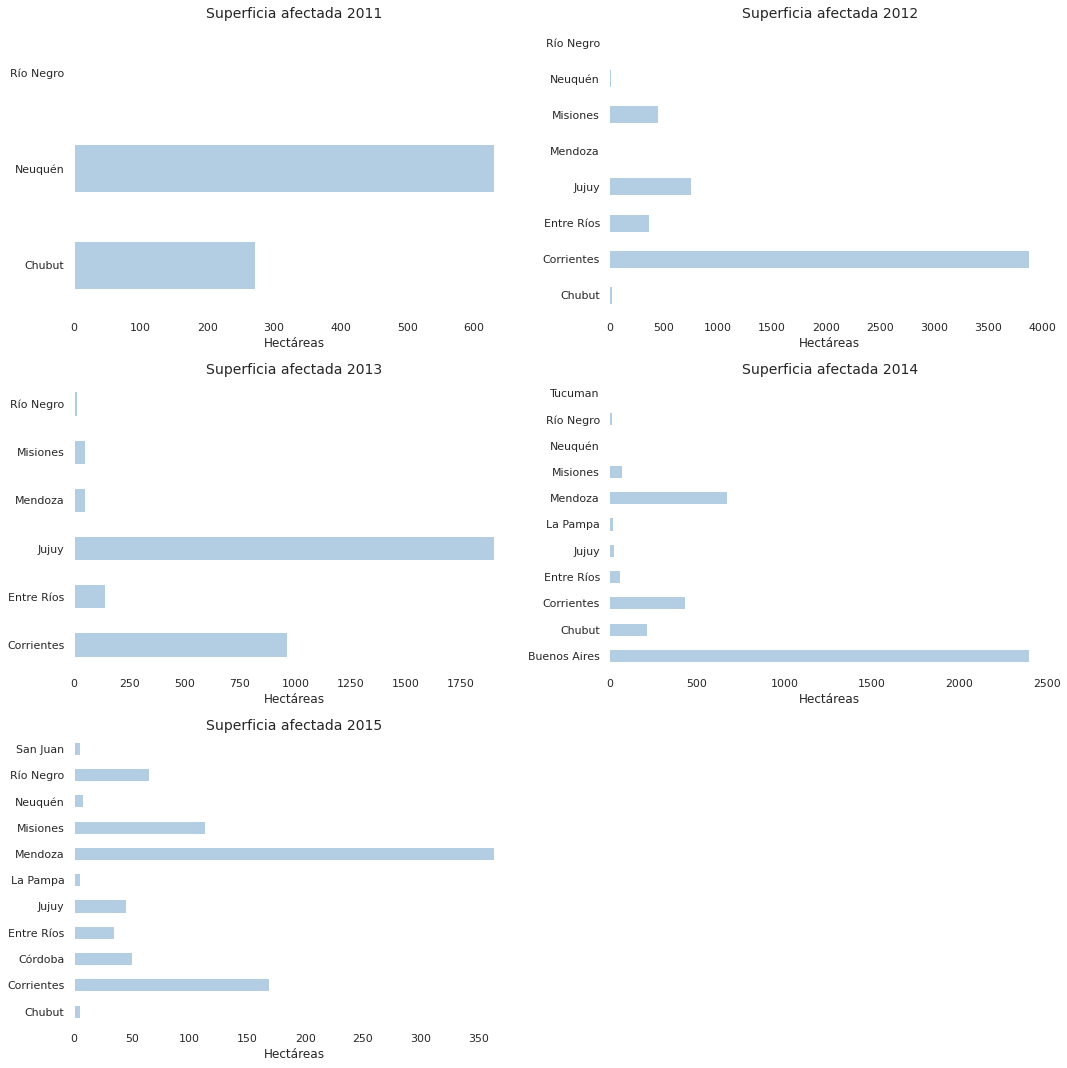

In [70]:
fig = plt.figure(figsize=(15,15))
for i, a_year in enumerate(area_by_year['año_inicial'].unique()):
    ax = fig.add_subplot(3,2,i+1)
    ax = area_by_year.loc[area_by_year['año_inicial'] == a_year].plot.barh(x='provincia', y='sup_afectada', legend=False, color='#B3CDE3', ax=plt.gca())
    ax.set_title(f"Superficia afectada {a_year}", size=14)
    ax.set_xlabel('Hectáreas')
    ax.set_ylabel('')
    plt.box(on=None)

plt.tight_layout()
plt.savefig('./evolucion_anio_provincia.png')

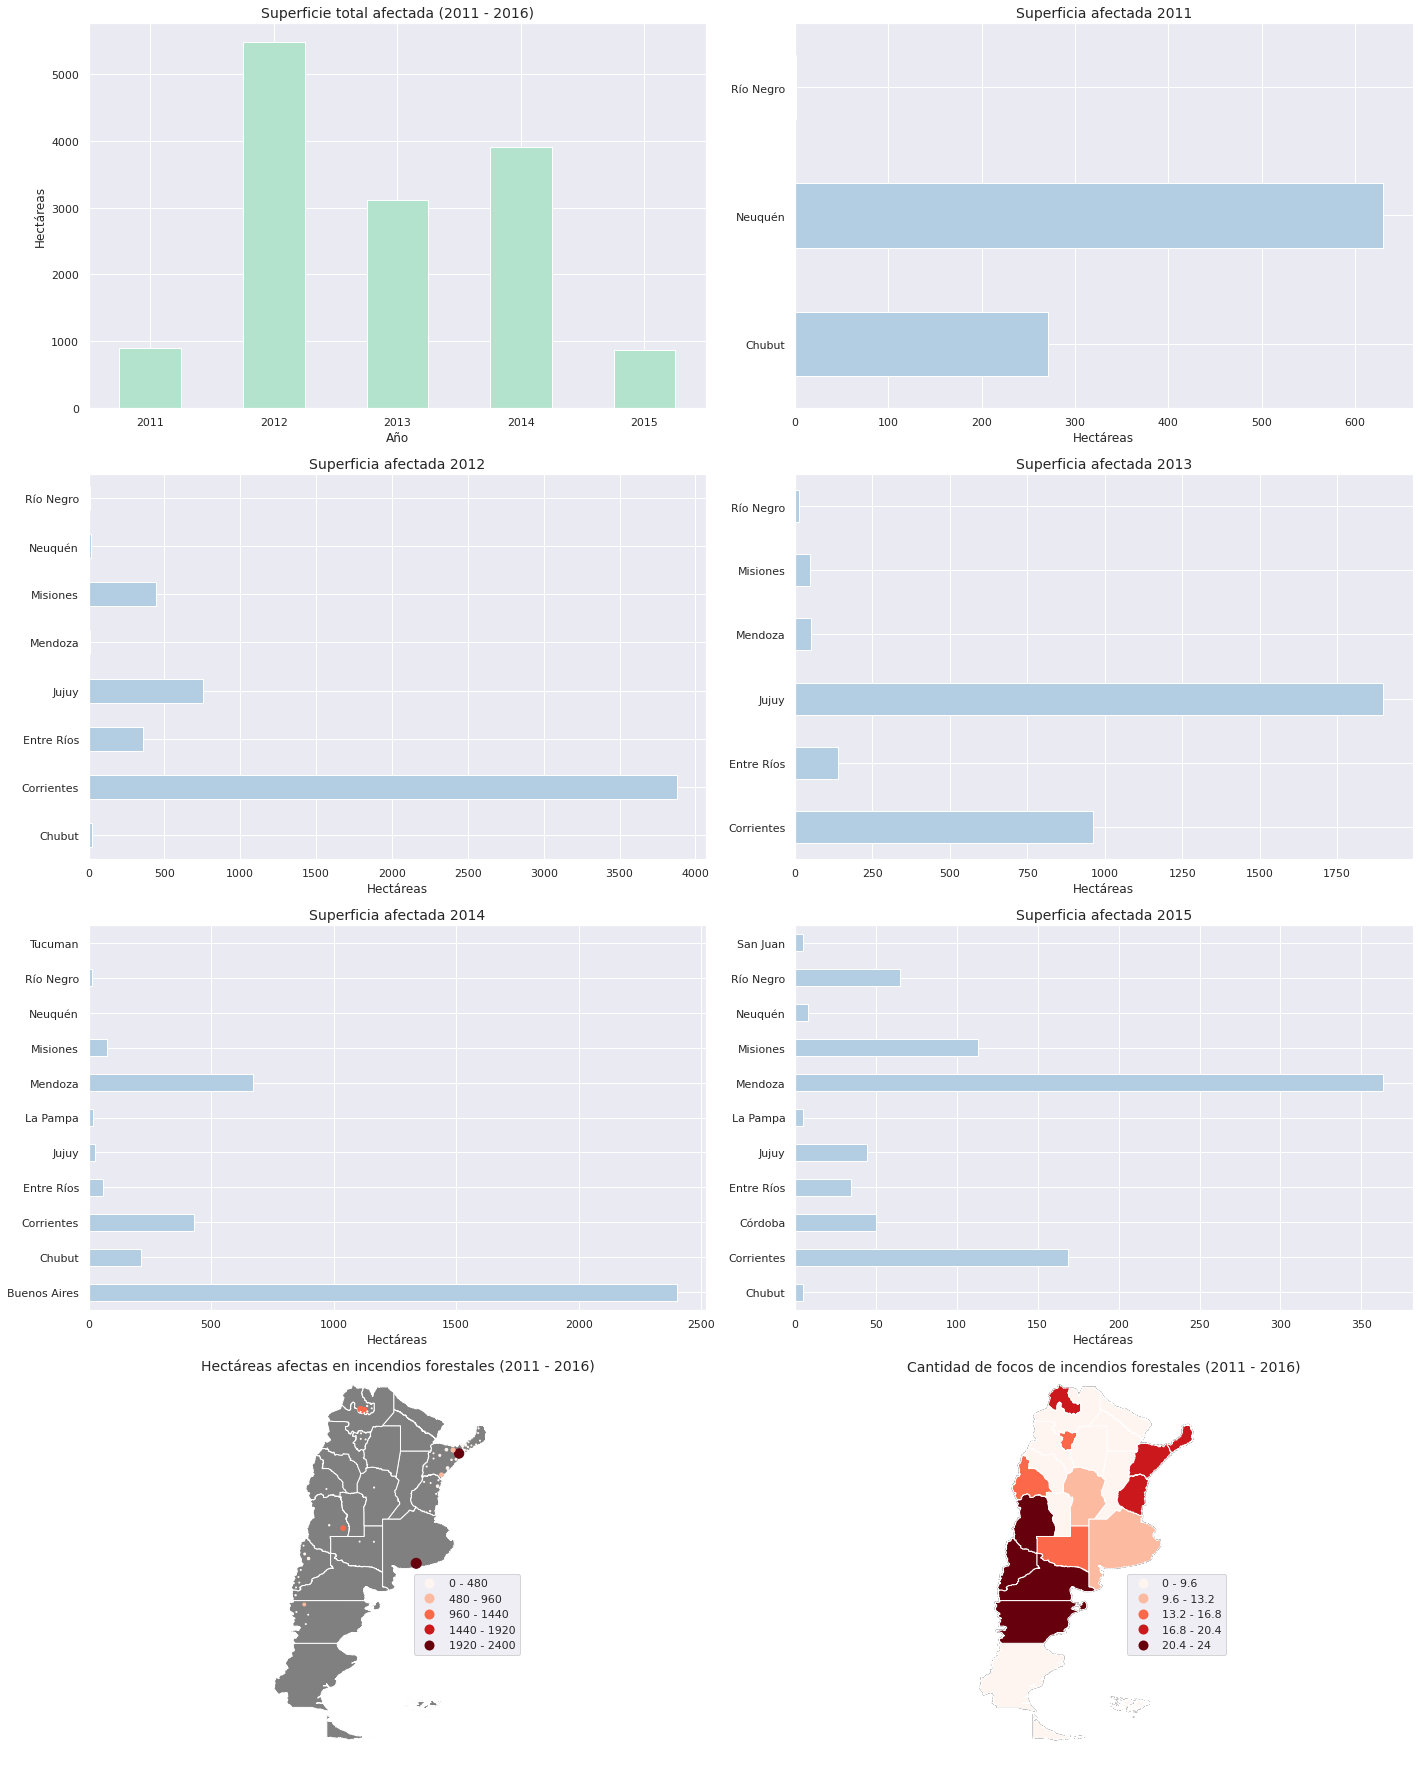

In [108]:
f, axes = plt.subplots(figsize=(20, 25), ncols=2, nrows=4)

ax = start_by_year.plot.bar(x='año_inicial', y=['superficie_total_inicio'],
                      rot=0, legend=False, colormap='Pastel2', ax=axes[0][0])
ax.set_title("Superficie total afectada (2011 - 2016)", size=14)
ax.set_ylabel('Hectáreas')
ax.set_xlabel('Año')
#ax.legend(["Superficie quemada"],loc='upper center', fancybox=True, bbox_to_anchor=(1.2, 1))

map_to_coord = {0: (0,1), 1: (1,0), 2: (1,1), 3: (2,0), 4: (2,1)}
for i, a_year in enumerate(area_by_year['año_inicial'].unique()):
    ax = area_by_year.loc[area_by_year['año_inicial'] == a_year].plot.barh(
        x='provincia', y='sup_afectada', legend=False, color='#B3CDE3', ax=axes[map_to_coord[i][0]][map_to_coord[i][1]])
    ax.set_title(f"Superficia afectada {a_year}", size=14)
    ax.set_xlabel('Hectáreas')
    ax.set_ylabel('')
    plt.tight_layout()

ax = gplt.pointplot(geo_departments_to_plot, scale='counts', hue='counts',
                    scheme='EqualInterval', legend=True, legend_var='hue',
                    limits=(1, 10), cmap='Reds',
                    legend_kwargs={'loc': 'upper right', 'bbox_to_anchor': (0.5, 0., 0.5, 0.5)}, ax=axes[3][0])
ax.set_title("Hectáreas afectas en incendios forestales (2011 - 2016)", size=14)
gplt.polyplot(geo_provinces_to_plot, ax=axes[3][0], edgecolor='white', facecolor='gray', extent=[-74.0, -57.0, -50.0, -21.0])

ax = gplt.choropleth(geo_provinces_to_plot, hue='rank', scheme='EqualInterval',
                    legend=True, cmap='Reds',
                    legend_kwargs={'loc': 'upper right', 'bbox_to_anchor': (0.5, 0., 0.5, 0.5)}, ax=axes[3][1])
ax.set_title("Cantidad de focos de incendios forestales (2011 - 2016)", size=14)
gplt.polyplot(geo_provinces_to_plot, ax=axes[3][1], extent=[-74.0, -57.0, -50.0, -21.0])

plt.savefig('./final.png')